Projekat 1 - optimizovana verzija

Filip Nikolić   
Jovan Dimitrijević

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

Priprema podataka za treniranje modela

In [ ]:
df = pd.read_csv('parkinsons_updrs.csv')

X = df.drop(['subject#', 'test_time', 'total_UPDRS', 'motor_UPDRS'], axis=1)
y_total_UPDRS = df['total_UPDRS']

X_train, X_test, y_train_total_UPDRS, y_test_total_UPDRS = train_test_split(X, y_total_UPDRS, test_size=0.2, random_state=42)

# Standizacija podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Selekcija fičera na osnovu koeficijenata korelacije

In [ ]:
num_features_to_select = 7  # Adjust the number of features to select

selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_train_selected = selector.fit_transform(X_train, y_train_total_UPDRS)
X_test_selected = selector.transform(X_test)

Optimizacija hiperparametara decision_tree modela

In [ ]:
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object for DecisionTreeRegressor
grid_search_decision_tree = GridSearchCV(DecisionTreeRegressor(random_state=42),
                                         param_grid_decision_tree,
                                         cv=5,  # 5-fold cross-validation
                                         scoring=['neg_mean_squared_error', 'r2'],  # Use multiple scoring metrics
                                         refit='r2',  # Choose R-squared for refitting
                                         n_jobs=-1)  # Use all available CPU cores

# Fit the grid search to the data using the selected features
grid_search_decision_tree.fit(X_train_selected, y_train_total_UPDRS)

# Get the best parameters and the best estimator for DecisionTreeRegressor
best_params_decision_tree = grid_search_decision_tree.best_params_
best_estimator_decision_tree = grid_search_decision_tree.best_estimator_

# Print the best parameters for DecisionTreeRegressor
print("Best Hyperparameters for DecisionTreeRegressor:", best_params_decision_tree)

# Use the best estimator of DecisionTreeRegressor to make predictions on the test set with selected features
y_pred_optimized_decision_tree = best_estimator_decision_tree.predict(X_test_selected)

# Calculate metrics with the optimized DecisionTreeRegressor model
mse_total_UPDRS_optimized_decision_tree = mean_squared_error(y_test_total_UPDRS, y_pred_optimized_decision_tree)
r2_total_UPDRS_optimized_decision_tree = r2_score(y_test_total_UPDRS, y_pred_optimized_decision_tree)

# Print metrics for the optimized DecisionTreeRegressor model
print(f'Optimized Mean Squared Error (total_UPDRS) for DecisionTreeRegressor: {mse_total_UPDRS_optimized_decision_tree}')
print(f'Optimized R-squared (total_UPDRS) for DecisionTreeRegressor: {r2_total_UPDRS_optimized_decision_tree}')

Best Hyperparameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Optimized Mean Squared Error (total_UPDRS) for DecisionTreeRegressor: 17.476841957677216
Optimized R-squared (total_UPDRS) for DecisionTreeRegressor: 0.8422853354269612


Vizuelizacija rezultata optimizacije hiperparametara

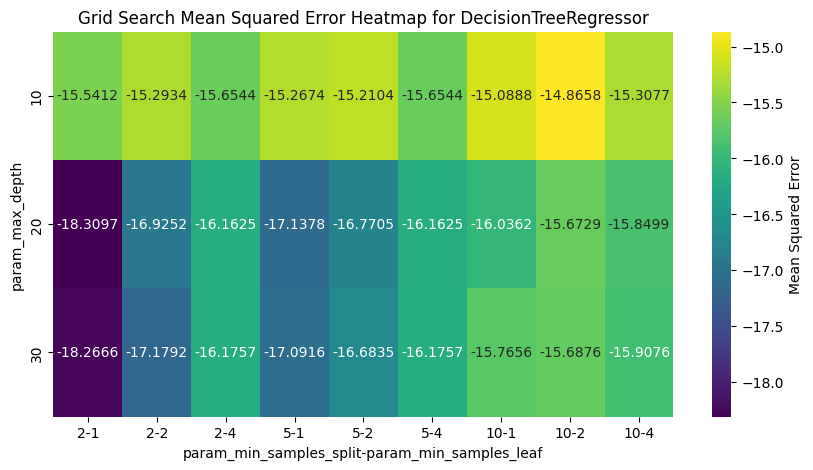

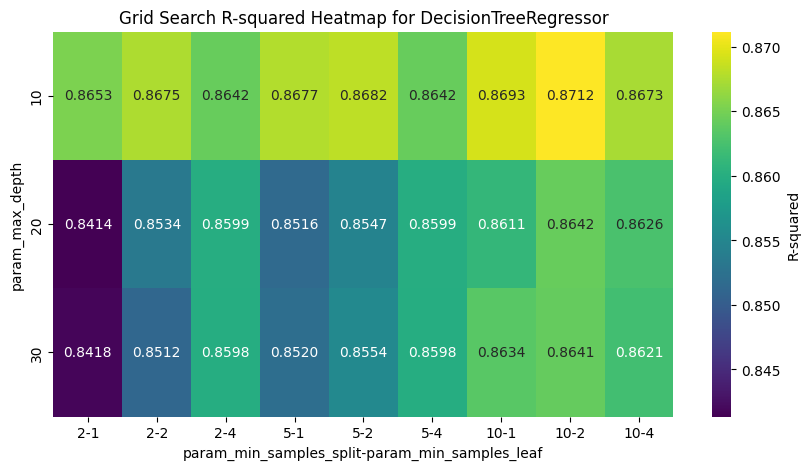

In [ ]:
# Get the results of the grid search for DecisionTreeRegressor
results_decision_tree = pd.DataFrame(grid_search_decision_tree.cv_results_)

# Extract relevant columns from the results DataFrame for DecisionTreeRegressor
columns_decision_tree = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
                          'mean_test_neg_mean_squared_error', 'mean_test_r2']
hyperparam_results_decision_tree = results_decision_tree[columns_decision_tree]

# Reshape the results DataFrame for visualization for DecisionTreeRegressor
heatmap_data_mse_decision_tree = hyperparam_results_decision_tree.pivot_table(
    values='mean_test_neg_mean_squared_error',
    index='param_max_depth',
    columns=['param_min_samples_split', 'param_min_samples_leaf'])

heatmap_data_r2_decision_tree = hyperparam_results_decision_tree.pivot_table(
    values='mean_test_r2',
    index='param_max_depth',
    columns=['param_min_samples_split', 'param_min_samples_leaf'])

# Create a heatmap for Mean Squared Error for DecisionTreeRegressor
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data_mse_decision_tree, annot=True, fmt=".4f", cmap='viridis',
            cbar_kws={'label': 'Mean Squared Error'})
plt.title('Grid Search Mean Squared Error Heatmap for DecisionTreeRegressor')
plt.show()

# Create a heatmap for R-squared for DecisionTreeRegressor
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data_r2_decision_tree, annot=True, fmt=".4f", cmap='viridis',
            cbar_kws={'label': 'R-squared'})
plt.title('Grid Search R-squared Heatmap for DecisionTreeRegressor')
plt.show()

Optimizacija hiperparametara K-NN modela

In [ ]:
param_grid_knn = {
  'n_neighbors': [3, 5, 7, 9, 11],
  'weights': ['uniform', 'distance'],
  'p': [1, 2]
}

# Create the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(KNeighborsRegressor(),
                              param_grid_knn,
                              cv=5,  # 5-fold cross-validation
                              scoring=['neg_mean_squared_error', 'r2'],  # Use multiple scoring metrics
                              refit='r2',  # Choose R-squared for refitting
                              n_jobs=-1)  # Use all available CPU cores

# Fit the grid search to the data using the selected features
grid_search_knn.fit(X_train_selected, y_train_total_UPDRS)

# Get the best parameters and the best estimator for KNN
best_params_knn = grid_search_knn.best_params_
best_estimator_knn = grid_search_knn.best_estimator_

print("Best Hyperparameters (KNN):", best_params_knn)

# Use the best estimator to make predictions on the test set with selected features for KNN
y_pred_optimized_knn = best_estimator_knn.predict(X_test_selected)

# Calculate metrics with the optimized model for KNN
mse_total_UPDRS_optimized_knn = mean_squared_error(y_test_total_UPDRS, y_pred_optimized_knn)
r2_total_UPDRS_optimized_knn = r2_score(y_test_total_UPDRS, y_pred_optimized_knn)

# Print metrics for the optimized model for KNN
print(f'Optimized Mean Squared Error (total_UPDRS) for KNN: {mse_total_UPDRS_optimized_knn}')
print(f'Optimized R-squared (total_UPDRS) for KNN: {r2_total_UPDRS_optimized_knn}')

Best Hyperparameters (KNN): {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Optimized Mean Squared Error (total_UPDRS) for KNN: 13.654064866892025
Optimized R-squared (total_UPDRS) for KNN: 0.8767828726863078


Vizuelizacija rezultata optimizacije hiperparametara

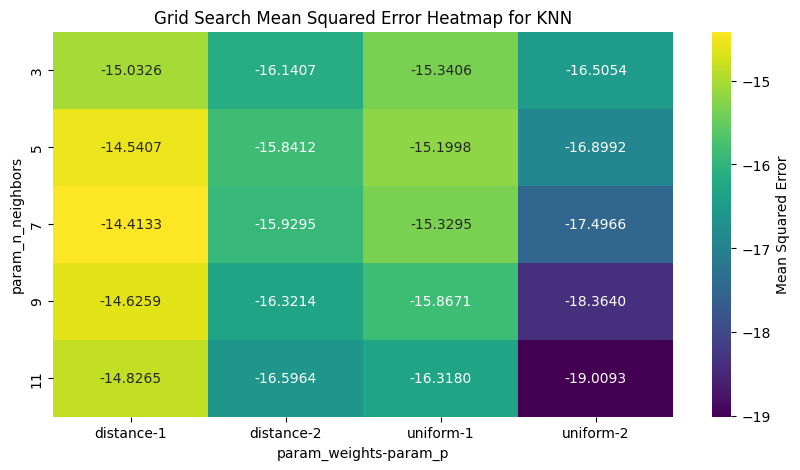

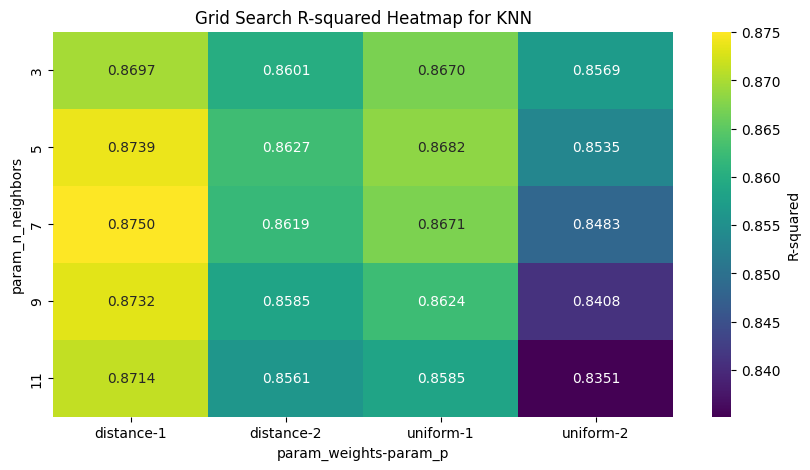

In [ ]:
# Get the results of the grid search for KNN
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Extract relevant columns from the results DataFrame for KNN
columns_knn = ['param_n_neighbors', 'param_weights', 'param_p', 'mean_test_neg_mean_squared_error', 'mean_test_r2']
hyperparam_results_knn = results_knn[columns_knn]

# Reshape the results DataFrame for visualization for KNN
heatmap_data_mse_knn = hyperparam_results_knn.pivot_table(values='mean_test_neg_mean_squared_error',
  index='param_n_neighbors',
  columns=['param_weights', 'param_p'])

heatmap_data_r2_knn = hyperparam_results_knn.pivot_table(values='mean_test_r2',
  index='param_n_neighbors',
  columns=['param_weights', 'param_p'])

# Create a heatmap for Mean Squared Error for KNN
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data_mse_knn, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'Mean Squared Error'})
plt.title('Grid Search Mean Squared Error Heatmap for KNN')
plt.show()

# Create a heatmap for R-squared for KNN
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data_r2_knn, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'R-squared'})
plt.title('Grid Search R-squared Heatmap for KNN')
plt.show()

Optimizacija hiperparametara random_forest modela

In [2]:
# Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid_rf,
                               cv=5,
                               scoring=['neg_mean_squared_error', 'r2'],
                               refit='r2',
                               n_jobs=-1)

grid_search_rf.fit(X_train_selected, y_train_total_UPDRS)

best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_

print("Best Hyperparameters (Random Forest):", best_params_rf)

y_pred_optimized_rf = best_estimator_rf.predict(X_test_selected)

mse_total_UPDRS_optimized_rf = mean_squared_error(y_test_total_UPDRS, y_pred_optimized_rf)
r2_total_UPDRS_optimized_rf = r2_score(y_test_total_UPDRS, y_pred_optimized_rf)

print(f'Optimized Mean Squared Error (total_UPDRS) for Random Forest: {mse_total_UPDRS_optimized_rf}')
print(f'Optimized R-squared (total_UPDRS) for Random Forest: {r2_total_UPDRS_optimized_rf}')

Best Hyperparameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Optimized Mean Squared Error (total_UPDRS) for Random Forest: 10.099333049078433
Optimized R-squared (total_UPDRS) for Random Forest: 0.9088615135329343


Vizuelizacija rezultata optimizacije hiperparametara

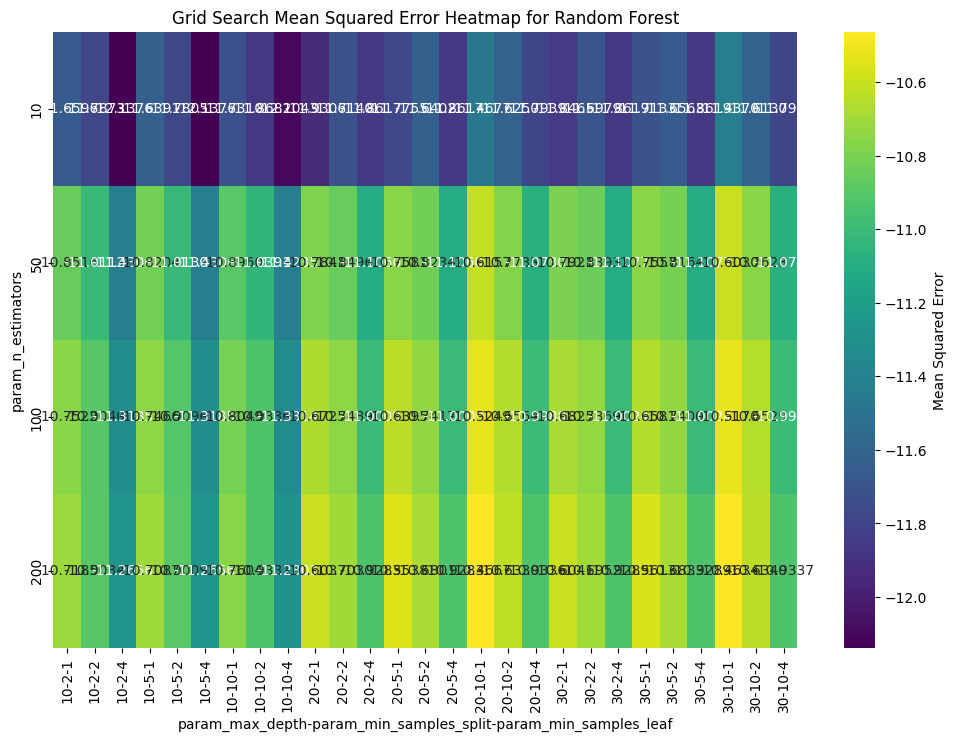

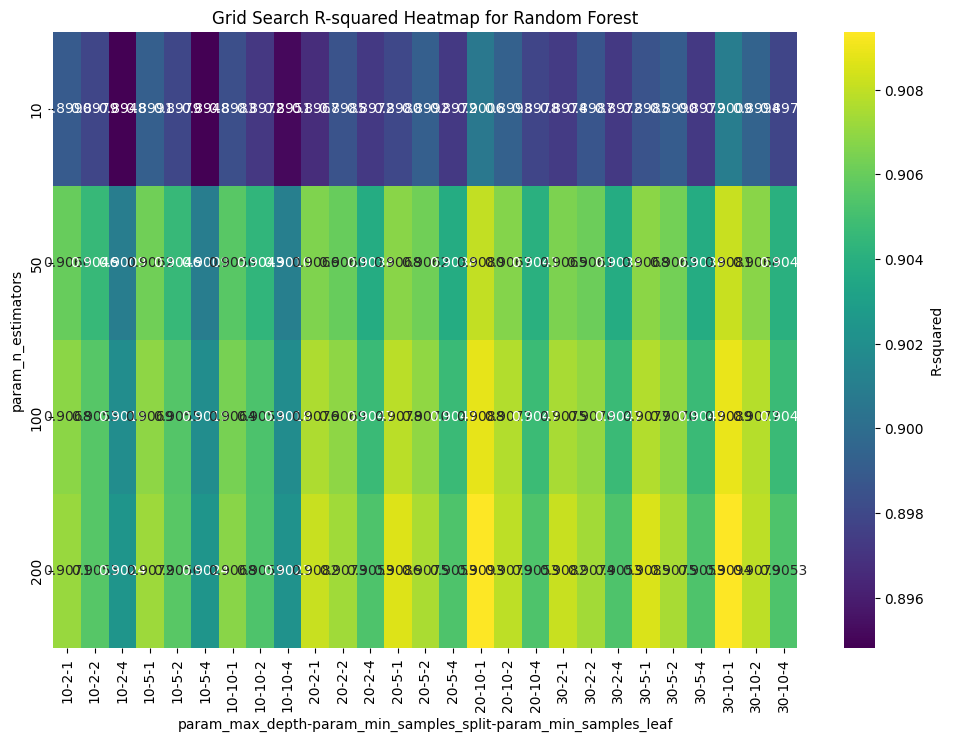

In [3]:
# Get the results of the grid search for Random Forest
results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# Extract relevant columns from the results DataFrame for Random Forest
columns_rf = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_neg_mean_squared_error', 'mean_test_r2']
hyperparam_results_rf = results_rf[columns_rf]

# Reshape the results DataFrame for visualization for Random Forest
heatmap_data_mse_rf = hyperparam_results_rf.pivot_table(values='mean_test_neg_mean_squared_error',
                                                        index='param_n_estimators',
                                                        columns=['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'])

heatmap_data_r2_rf = hyperparam_results_rf.pivot_table(values='mean_test_r2',
                                                       index='param_n_estimators',
                                                       columns=['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf'])

# Create a heatmap for Mean Squared Error for Random Forest
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_mse_rf, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'Mean Squared Error'})
plt.title('Grid Search Mean Squared Error Heatmap for Random Forest')
plt.show()

# Create a heatmap for R-squared for Random Forest
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_r2_rf, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'R-squared'})
plt.title('Grid Search R-squared Heatmap for Random Forest')
plt.show()

Optimizacija hiperparametara gradient_boost modela

In [ ]:
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object for Gradient Boosting
grid_search_gb = GridSearchCV(GradientBoostingRegressor(),
                               param_grid_gb,
                               cv=5,
                               scoring=['neg_mean_squared_error', 'r2'],
                               refit='r2',
                               n_jobs=-1)

# Fit the grid search to the data using the selected features
grid_search_gb.fit(X_train_selected, y_train_total_UPDRS)

# Get the best parameters and the best estimator for Gradient Boosting
best_params_gb = grid_search_gb.best_params_
best_estimator_gb = grid_search_gb.best_estimator_

# Print the best parameters for Gradient Boosting
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Use the best estimator to make predictions on the test set with selected features for Gradient Boosting
y_pred_optimized_gb = best_estimator_gb.predict(X_test_selected)

# Calculate metrics with the optimized model for Gradient Boosting
mse_total_UPDRS_optimized_gb = mean_squared_error(y_test_total_UPDRS, y_pred_optimized_gb)
r2_total_UPDRS_optimized_gb = r2_score(y_test_total_UPDRS, y_pred_optimized_gb)

# Print metrics for the optimized model for Gradient Boosting
print(f'Optimized Mean Squared Error (total_UPDRS) for Gradient Boosting: {mse_total_UPDRS_optimized_gb}')
print(f'Optimized R-squared (total_UPDRS) for Gradient Boosting: {r2_total_UPDRS_optimized_gb}')

Best Hyperparameters (Gradient Boosting): {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Optimized Mean Squared Error (total_UPDRS) for Gradient Boosting: 11.476926633210198
Optimized R-squared (total_UPDRS) for Gradient Boosting: 0.8964298218940526


Vizuelizacija rezultata optimizacije hiperparametara

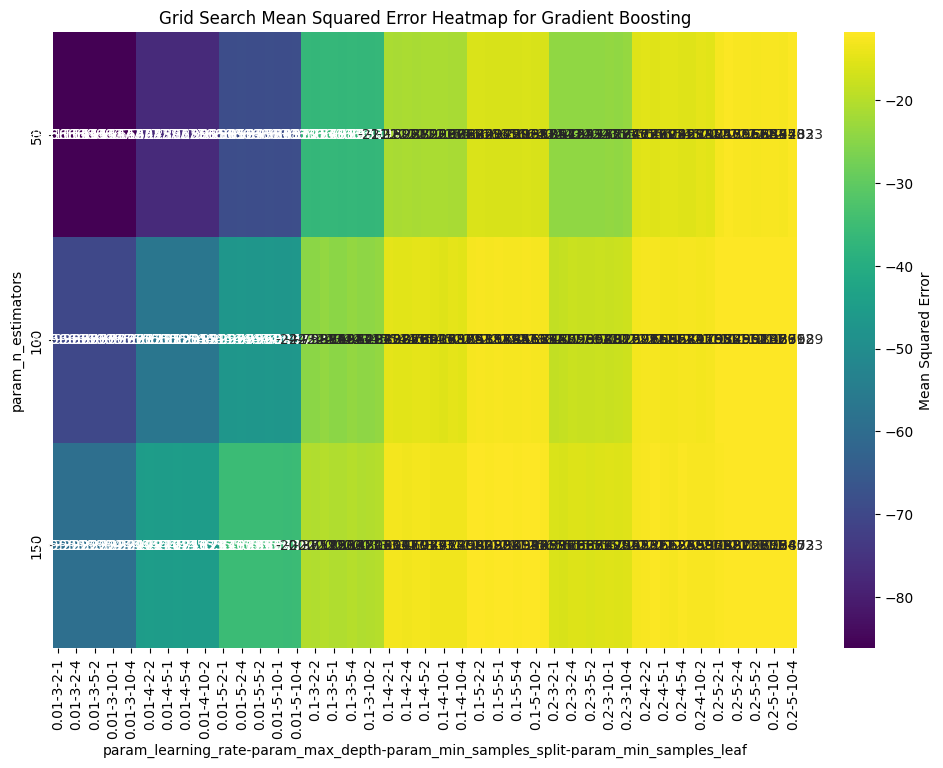

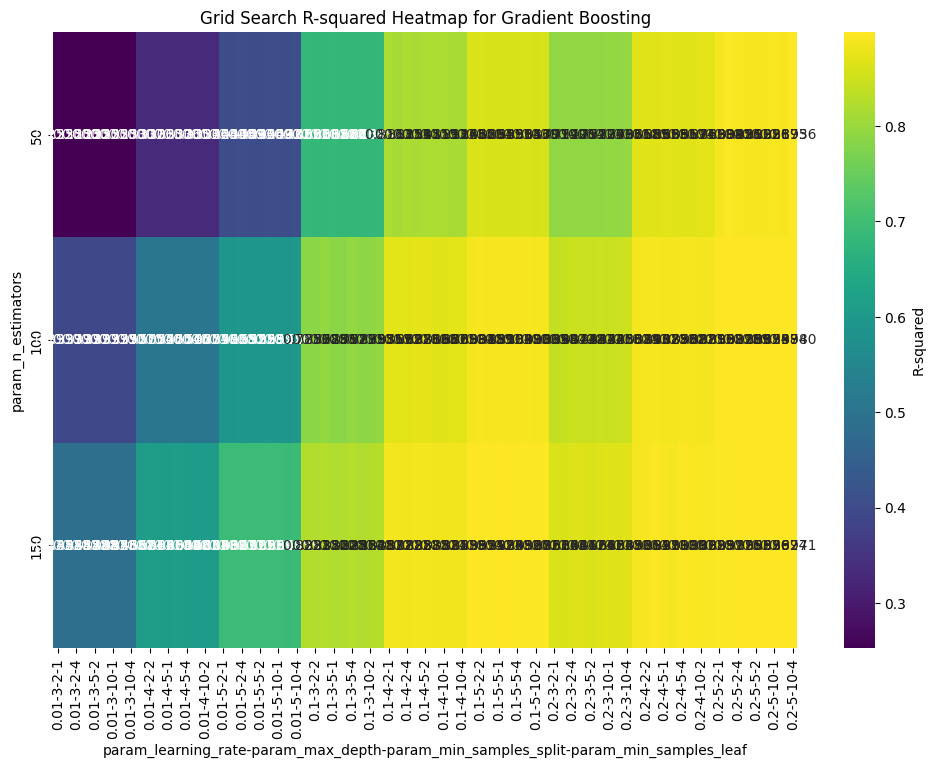

In [4]:
# Get the results of the grid search for Gradient Boosting
results_gb = pd.DataFrame(grid_search_gb.cv_results_)

# Extract relevant columns from the results DataFrame for Gradient Boosting
columns_gb = ['param_n_estimators', 'param_learning_rate', 'param_max_depth',
              'param_min_samples_split', 'param_min_samples_leaf',
              'mean_test_neg_mean_squared_error', 'mean_test_r2']
hyperparam_results_gb = results_gb[columns_gb]

# Reshape the results DataFrame for visualization for Gradient Boosting
heatmap_data_mse_gb = hyperparam_results_gb.pivot_table(values='mean_test_neg_mean_squared_error',
  index='param_n_estimators',
  columns=['param_learning_rate', 'param_max_depth',
           'param_min_samples_split', 'param_min_samples_leaf'])

heatmap_data_r2_gb = hyperparam_results_gb.pivot_table(values='mean_test_r2',
  index='param_n_estimators',
  columns=['param_learning_rate', 'param_max_depth',
           'param_min_samples_split', 'param_min_samples_leaf'])

# Create a heatmap for Mean Squared Error for Gradient Boosting
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_mse_gb, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'Mean Squared Error'})
plt.title('Grid Search Mean Squared Error Heatmap for Gradient Boosting')
plt.show()

# Create a heatmap for R-squared for Gradient Boosting
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_r2_gb, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'R-squared'})
plt.title('Grid Search R-squared Heatmap for Gradient Boosting')
plt.show()

Optimizacija hiperparametara XGBoost modela

In [5]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42),
                                  param_grid_xgb,
                                  cv=5,
                                  scoring=['neg_mean_squared_error', 'r2'],
                                  refit='r2',
                                  n_jobs=-1)

grid_search_xgb.fit(X_train_selected, y_train_total_UPDRS)

best_params_xgb = grid_search_xgb.best_params_
best_estimator_xgb = grid_search_xgb.best_estimator_

print("Best Hyperparameters (XGBoost):", best_params_xgb)

y_pred_optimized_xgb = best_estimator_xgb.predict(X_test_selected)

mse_total_UPDRS_optimized_xgb = mean_squared_error(y_test_total_UPDRS, y_pred_optimized_xgb)
r2_total_UPDRS_optimized_xgb = r2_score(y_test_total_UPDRS, y_pred_optimized_xgb)

print(f'Optimized Mean Squared Error (total_UPDRS) for XGBoost: {mse_total_UPDRS_optimized_xgb}')
print(f'Optimized R-squared (total_UPDRS) for XGBoost: {r2_total_UPDRS_optimized_xgb}')

Best Hyperparameters (XGBoost): {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Optimized Mean Squared Error (total_UPDRS) for XGBoost: 11.474801409211834
Optimized R-squared (total_UPDRS) for XGBoost: 0.8964490003583803
